<a href="https://colab.research.google.com/github/deepakri201/SEG_and_SR_for_NLSTSeg/blob/main/read_seg_and_sr_demo/NLSTSeg_demo_read_SEG_and_SR_and_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read SEG and SR using highdicom

Here we demonstrate how to read the DICOM SEG file using pydicom/highdicom and plot the segmentation. We also show how to read a DICOM SR to obtain the features for a single series.

Deepa Krishnaswamy

Brigham and Women's Hospital

September 2025

# Install highdicom from github

In [15]:
!git clone https://github.com/imagingdatacommons/highdicom ~/highdicom

Cloning into '/root/highdicom'...
remote: Enumerating objects: 8342, done.
remote: Counting objects: 100% (1926/1926), done.
remote: Compressing objects: 100% (287/287), done.
remote: Total 8342 (delta 1782), reused 1642 (delta 1637), pack-reused 6416 (from 2)
Receiving objects: 100% (8342/8342), 6.82 MiB | 10.11 MiB/s, done.
Resolving deltas: 100% (5518/5518), done.


In [16]:
!pip install ~/highdicom

Processing /root/highdicom
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 21.3 MB/s eta 0:00:00
  Created wheel for highdicom: filename=highdicom-0.26.1-py3-none-any.whl size=1106466 sha256=0907ace11eb7f8fa05f62e1f713e5fa60778bd9427579fd9eb5d5427e74a2139
  Stored in directory: /tmp/pip-ephem-wheel-cache-tpr3dtrd/wheels/e1/2a/ca/e605fe591961d04f0a82d0ca4d8593aaeeba598f4a9c806a09
Successfully built highdicom


# Parameterization

In [1]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install idc-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2


In [7]:
from idc_index import IDCClient

idc_client = IDCClient.client()

In [9]:
!pip install pydicom
import pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.2 MB/s eta 0:00:00


In [10]:
# DCMQI - to convert nifti to DICOM Segmentation object
!wget https://github.com/QIICR/dcmqi/releases/download/v1.4.0/dcmqi-1.4.0-linux.tar.gz
!tar zxvf dcmqi-1.4.0-linux.tar.gz
!cp dcmqi-1.4.0-linux/bin/* /usr/local/bin/

--2025-09-22 21:09:01--  https://github.com/QIICR/dcmqi/releases/download/v1.4.0/dcmqi-1.4.0-linux.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/50675718/915cb14a-48f5-4288-9a5f-bfbcc67daf43?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-22T21%3A58%3A37Z&rscd=attachment%3B+filename%3Ddcmqi-1.4.0-linux.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-22T20%3A58%3A16Z&ske=2025-09-22T21%3A58%3A37Z&sks=b&skv=2018-11-09&sig=0QUddtxVo6oX1fhNkZOy%2FikeFGGA11RKdTLRmgQhnaU%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODU3NTY0MSwibmJmIjoxNzU4NTc1MzQxLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHV

In [12]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 14.0 MB/s eta 0:00:00


In [13]:
import os
import sys
import time

from google.cloud import bigquery
from google.cloud import storage

import numpy as np
import pandas as pd
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

import json
from pathlib import Path

import pydicom
from pydicom.uid import generate_uid
from pydicom.filereader import dcmread
from pydicom.sr.codedict import codes

In [17]:
from highdicom.sr.content import (
    FindingSite,
    ImageRegion,
    ImageRegion3D,
    SourceImageForRegion
)

from highdicom.sr.enum import GraphicTypeValues3D
from highdicom.sr.enum import GraphicTypeValues
from highdicom.sr.sop import Comprehensive3DSR, ComprehensiveSR
from highdicom.sr.templates import (
    DeviceObserverIdentifyingAttributes,
    Measurement,
    MeasurementProperties,
    MeasurementReport,
    ObservationContext,
    ObserverContext,
    PersonObserverIdentifyingAttributes,
    PlanarROIMeasurementsAndQualitativeEvaluations,
    RelationshipTypeValues,
    TrackingIdentifier,
    QualitativeEvaluation
)
# from highdicom.sr.value_types import (
#     CodedConcept,
#     CodeContentItem,
# )
# why from highdicom.sr.value_types for CodedConcept? Should be highdicom.sr.CodedConcept
from highdicom.sr import CodedConcept

from highdicom.sr import ImageLibrary
from highdicom.sr import ImageLibraryEntryDescriptors
from highdicom.sr.value_types import Code
from highdicom.sr.value_types import ContentItem
from highdicom.sr import PixelOriginInterpretationValues

import logging
logger = logging.getLogger("highdicom.sr.sop")
logger.setLevel(logging.INFO)

In [18]:
import highdicom as hd
hd.__version__

'0.26.1'

In [19]:
pydicom.__version__

'3.0.1'

# DICOM SEG file

In [ ]:
# Get a single SEG file using dcmqi

# Get the underlying CT data

# Plot the SEG on the CT data using itkwidgets?

# Alternatively read the SEG file using highdicom

## Get a single SEG file

In [20]:
# For now we copy from bucket

SeriesInstanceUID_CT = "1.2.840.113654.2.55.101995309829064050675770434766964356695"
seg_filename_bucket = os.path.join("gs://nlstseg_seg_and_sr/seg", SeriesInstanceUID_CT + "_SEG.dcm")
seg_filename = "/content/seg.dcm"
!gsutil cp $seg_filename_bucket $seg_filename

Copying gs://nlstseg_seg_and_sr/seg/1.2.840.113654.2.55.101995309829064050675770434766964356695_SEG.dcm...
/ [1 files][492.2 KiB/492.2 KiB]                                                
Operation completed over 1 objects/492.2 KiB.                                    


## Read the SEG file using dcmqi

In [25]:
# This will save a single nifti file with multiple lesions if present
if not os.path.isdir("/content/seg_output"):
  os.mkdir("/content/seg_output")
!segimage2itkimage -t "nii" --outputDirectory "/content/seg_output" --inputDICOM "/content/seg.dcm"  --mergeSegments

# Let's print what's in the json file
json_filename = "/content/seg_output/meta.json"
with open(json_filename, 'r') as file:
  seg_data = json.load(file)
seg_data_pretty = json.dumps(seg_data, indent=2)
print(seg_data_pretty)


dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
Loading DICOM SEG file /content/seg.dcm
Row direction: 1 0 0
Col direction: 0 1 0
Z direction: 0 0 1
Total frames: 15
Total frames with unique IPP: 15
Total overlapping frames: 0
Origin: [-171.688, -336.688, -144.9]
Slice extent: 28
Slice spacing: 2
Image Orientation Patient set to : 1, 0, 0, 0, 1, 0
Identified 1 groups of non-overlapping segments
Writing itk image to /content/seg_output/1.nii.gz ... done
{
  "BodyPartExamined": "CHEST",
  "ClinicalTrialCoordinatingCenterName": "dcmqi",
  "ClinicalTrialSeriesID": "0",
  "ClinicalTrialTimePointID": "1",
  "ContentCreatorName": "IDC",
  "InstanceNumber": "1",
  "SeriesDescription": "NLSTSeg Segmentation of Series: 3",
  "SeriesNumber": "300",
  "segmentAttributes": [
    [
      {
        "SegmentAlgorithmType": "MANUAL",
        "SegmentDescription": "Small cell carcinoma",
        "SegmentLabel": "Small cell carcinoma",
        "SegmentedPropertyCategory

## Read the SEG file using highdicom

In [28]:
# Can also read the SEG file using highdicom
seg = hd.seg.segread("/content/seg.dcm")

# Get the source images from this segmentation
sop_uid_list = []
for study_uid, series_uid, sop_uid in seg.get_source_image_uids():
  sop_uid_list.append(sop_uid)

print('sop_uid_list: ' + str(sop_uid_list))
print('num slices: ' + str(len(sop_uid_list)))

# To access information about each slice, we access the PerFrameFunctionalGroups
pffg = seg.PerFrameFunctionalGroupsSequence


sop_uid_list: ['1.2.840.113654.2.55.38952917921563170422527978032596134915', '1.2.840.113654.2.55.71440449741836925830124654521535102333', '1.2.840.113654.2.55.20596003796711986437292081968940697214', '1.2.840.113654.2.55.196924450952105956413495392825132499285', '1.2.840.113654.2.55.240527239613266962281907375501793999891', '1.2.840.113654.2.55.300549912129183662568039041300706128657', '1.2.840.113654.2.55.73094053066706442147458513069975340849', '1.2.840.113654.2.55.332516464381718120120183717097857680063', '1.2.840.113654.2.55.47633822730854835270827267388166790102', '1.2.840.113654.2.55.282744835608585244702497642305866139249', '1.2.840.113654.2.55.57850794414751549933882574147232899175', '1.2.840.113654.2.55.139828717120781683907455517517594119588', '1.2.840.113654.2.55.59295346771655354582641660793869403936', '1.2.840.113654.2.55.49917700295995406201503361021895031743', '1.2.840.113654.2.55.224723061652590267592025877837965582372']
num slices: 15


In [30]:
# Here we can see the Derivation Image Sequence, which provides the referenced SOPInstanceUID
pffg[0]

(0008,9124)  Derivation Image Sequence  1 item(s) ---- 
   (0008,2112)  Source Image Sequence  1 item(s) ---- 
      (0008,1150) Referenced SOP Class UID            UI: CT Image Storage
      (0008,1155) Referenced SOP Instance UID         UI: 1.2.840.113654.2.55.38952917921563170422527978032596134915
      (0040,A170)  Purpose of Reference Code Sequence  1 item(s) ---- 
         (0008,0100) Code Value                          SH: '121322'
         (0008,0102) Coding Scheme Designator            SH: 'DCM'
         (0008,0104) Code Meaning                        LO: 'Source image for image processing operation'
         ---------
      ---------
   (0008,9215)  Derivation Code Sequence  1 item(s) ---- 
      (0008,0100) Code Value                          SH: '113076'
      (0008,0102) Coding Scheme Designator            SH: 'DCM'
      (0008,0104) Code Meaning                        LO: 'Segmentation'
      ---------
   ---------
(0020,9111)  Frame Content Sequence  1 item(s) ---- 
   

In [40]:
# To access the underlying pixel data of a particular slice, we can do the following
mask_data = seg.pixel_array
print('mask_data: ' + str(mask_data.shape))

# Note, if we had more than 1 lesion, we would have to match the index into pffg with the index to pixel_array, and would have to check the ReferencedSegmentNumber

mask_data: (15, 512, 512)


## Download the underlying CT data, and vizualize the SEG file

In [39]:
# Download the underlying CT data
# We download the data using idc-index

dicom_directory = "/content/ct"
if not os.path.isdir(dicom_directory):
  os.mkdir(dicom_directory)

# Download the CT series
idc_client.download_from_selection(
    seriesInstanceUID=SeriesInstanceUID_CT,
    downloadDir=dicom_directory,
    dirTemplate='',
    quiet=True
)

In [43]:
# Now let's create a dataframe df_plot that holds:
# SOPInstanceUID, mask_slice number, and the CT filename

df_plot = pd.DataFrame()
df_plot['SOPInstanceUID'] = sop_uid_list
df_plot['mask_slice'] = np.arange(0,len(sop_uid_list))

ct_files = [os.path.join("/content/ct", f) for f in os.listdir("/content/ct")]
sop_list = []
for n in range(0,len(ct_files)):
  dcm = pydicom.dcmread(ct_files[n])
  sop = dcm.SOPInstanceUID
  sop_list.append(sop)

df_ct = pd.DataFrame()
df_ct['SOPInstanceUID'] = sop_list
df_ct['filename'] = ct_files

df_plot = pd.merge(df_plot, df_ct, left_on='SOPInstanceUID', right_on='SOPInstanceUID')

# Order by mask_slice number
df_plot = df_plot.sort_values(by='mask_slice')

df_plot

,SOPInstanceUID,mask_slice,filename
0,1.2.840.113654.2.55.38952917921563170422527978...,0,/content/ct/ca045381-8a76-4d13-893d-9a8afa47b3...
1,1.2.840.113654.2.55.71440449741836925830124654...,1,/content/ct/cf3da352-4b9e-4bc3-865a-09d964f486...
2,1.2.840.113654.2.55.20596003796711986437292081...,2,/content/ct/02f82720-35a5-4724-8675-379aa47abf...
3,1.2.840.113654.2.55.19692445095210595641349539...,3,/content/ct/6967de8c-eaa8-4ac2-ad5c-3c9f2879c9...
4,1.2.840.113654.2.55.24052723961326696228190737...,4,/content/ct/8569c36b-bedd-4fc4-a2d3-cd952a8dd4...
5,1.2.840.113654.2.55.30054991212918366256803904...,5,/content/ct/4b3c7d40-10b6-44c8-8d9e-f051c13a3a...
6,1.2.840.113654.2.55.73094053066706442147458513...,6,/content/ct/c692c384-10f9-46bd-a3fc-aa7f65b2e5...
7,1.2.840.113654.2.55.33251646438171812012018371...,7,/content/ct/dc2cb046-946a-463d-9575-a721d38477...
8,1.2.840.113654.2.55.47633822730854835270827267...,8,/content/ct/b2ce127d-2c02-4f59-b22b-7354a1732c...
9,1.2.840.113654.2.55.28274483560858524470249764...,9,/content/ct/423288d8-9e36-42a2-9bde-b4b4403a6d...


num_overlapping_slices: 15
num_rows: 2
num_columns: 15


/tmp/ipython-input-3822649689.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


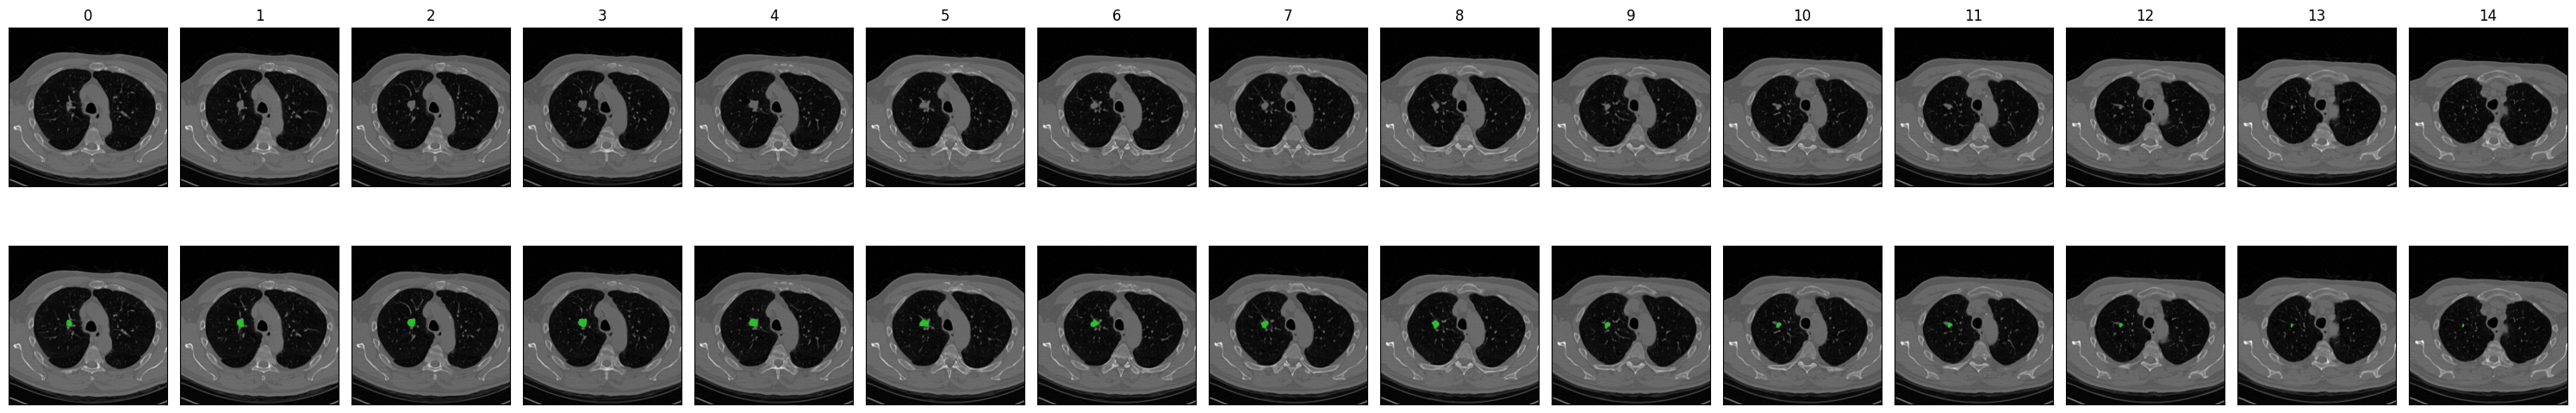

In [46]:
num_overlapping_slices = len(df_plot)
print('num_overlapping_slices: ' + str(num_overlapping_slices))

num_rows = 2
num_columns = num_overlapping_slices
print('num_rows: ' + str(num_rows))
print('num_columns: ' + str(num_columns))
fig, ax = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(num_overlapping_slices*2, 6), constrained_layout=True)

for n in range(0,num_overlapping_slices):

  col_index = n

  # Get the referenced SOPInstanceUID
  SOPInstanceUID = df_plot['SOPInstanceUID'].values[n]
  ct_filename = df_plot['filename'].values[n]

  # Get the CT data
  dcm = pydicom.dcmread(ct_filename)
  img = dcm.pixel_array

  # Plot the CT image
  ax[0,col_index].imshow(img, cmap='gray')
  ax[0,col_index].get_xaxis().set_visible(False)
  ax[0,col_index].get_yaxis().set_visible(False)
  ax[0,col_index].set_title(str(n))

  # Row for the CT image + nodule
  row_index = 1
  ax[row_index,col_index].imshow(img, cmap='gray')
  ax[row_index,col_index].get_xaxis().set_visible(False)
  ax[row_index,col_index].get_yaxis().set_visible(False)
  # Add the tumor segmentation for now
  # Add the segmentation to the plot
  mask_slice = mask_data[n,:,:]
  # ax[row_index,col_index].imshow(mask_slice, cmap='Reds', alpha=0.3)
  overlay = np.zeros((*mask_slice.shape, 4))
  # overlay[mask_slice > 0] = (*plt.cm.get_cmap('Blues')(1)[:3], 0.3)  # RGB + alpha
  overlay[mask_slice > 0] = (0, 1, 0, 0.6)  # RGB + alpha
  ax[row_index,col_index].imshow(overlay)

plt.tight_layout()
plt.show()


# DICOM SR file

In [48]:
# Download a SR that holds shape features, and another one that holds the first-order features
# For now we copy from bucket

sr_first_order_filename_bucket = os.path.join("gs://nlstseg_seg_and_sr/sr_first_order", SeriesInstanceUID_CT + "_sr.dcm")
sr_first_order_filename = "/content/sr_first_order.dcm"
!gsutil cp $sr_first_order_filename_bucket $sr_first_order_filename

sr_shape_filename_bucket = os.path.join("gs://nlstseg_seg_and_sr/sr_shape", SeriesInstanceUID_CT + "_sr.dcm")
sr_shape_filename = "/content/sr_shape.dcm"
!gsutil cp $sr_shape_filename_bucket $sr_shape_filename

Copying gs://nlstseg_seg_and_sr/sr_first_order/1.2.840.113654.2.55.101995309829064050675770434766964356695_sr.dcm...
/ [1 files][111.4 KiB/111.4 KiB]                                                
Operation completed over 1 objects/111.4 KiB.                                    
Copying gs://nlstseg_seg_and_sr/sr_shape/1.2.840.113654.2.55.101995309829064050675770434766964356695_sr.dcm...
/ [1 files][113.0 KiB/113.0 KiB]                                                
Operation completed over 1 objects/113.0 KiB.                                    


## Read the SR using dcmqi

In [49]:
# Read the first order SR
!tid1500reader --inputDICOM $sr_first_order_filename --outputMetadata "/content/sr_first_order.json"

# Let's print out the metadata
with open("/content/sr_first_order.json", 'r') as file:
  sr_first_order_data = json.load(file)
sr_first_order_data_pretty = json.dumps(sr_first_order_data, indent=2)
print(sr_first_order_data_pretty)

dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
{
  "CompletionFlag": "COMPLETE",
  "InstanceNumber": "1",
  "Measurements": [
    {
      "Finding": {
        "CodeMeaning": "Morphologically Altered Structure",
        "CodeValue": "49755003",
        "CodingSchemeDesignator": "SCT"
      },
      "FindingSite": {
        "CodeMeaning": "Small cell carcinoma",
        "CodeValue": "8041",
        "CodingSchemeDesignator": "ICD-03"
      },
      "ReferencedSegment": 1,
      "SourceSeriesForImageSegmentation": "1.2.840.113654.2.55.101995309829064050675770434766964356695",
      "TrackingIdentifier": "Measurements group 1",
      "TrackingUniqueIdentifier": "1.3.6.1.4.1.43046.3.1.4.481037312.243200.1758227055.769164",
      "activitySession": "1",
      "measurementAlgorithmIdentification": {
        "AlgorithmName": "pyradiomics",
        "AlgorithmVersion": "3.1.1.dev111+g8ed579383"
      },
      "measurementItems": [
        {
          "quantity"

In [50]:
# Read the shape SR
!tid1500reader --inputDICOM $sr_shape_filename --outputMetadata "/content/sr_shape.json"

# Let's print out the metadata
with open("/content/sr_shape.json", 'r') as file:
  sr_shape_data = json.load(file)
sr_shape_data_pretty = json.dumps(sr_shape_data, indent=2)
print(sr_shape_data_pretty)

dcmqi repository URL: https://github.com/QIICR/dcmqi revision: 4e5b700 tag: v1.4.0
{
  "CompletionFlag": "COMPLETE",
  "InstanceNumber": "1",
  "Measurements": [
    {
      "Finding": {
        "CodeMeaning": "Morphologically Altered Structure",
        "CodeValue": "49755003",
        "CodingSchemeDesignator": "SCT"
      },
      "FindingSite": {
        "CodeMeaning": "Small cell carcinoma",
        "CodeValue": "8041",
        "CodingSchemeDesignator": "ICD-03"
      },
      "ReferencedSegment": 1,
      "SourceSeriesForImageSegmentation": "1.2.840.113654.2.55.101995309829064050675770434766964356695",
      "TrackingIdentifier": "Measurements group 1",
      "TrackingUniqueIdentifier": "1.3.6.1.4.1.43046.3.1.4.481037312.243201.1758227056.996601",
      "activitySession": "1",
      "measurementAlgorithmIdentification": {
        "AlgorithmName": "pyradiomics",
        "AlgorithmVersion": "3.1.1.dev111+g8ed579383"
      },
      "measurementItems": [
        {
          "quantity"

## Read the SR using highdicom

In [84]:
def get_finding_sites(container):
    """Extract finding sites from a ContainerContentItem."""
    sites = []
    for item in container.ContentSequence:
        if "ConceptNameCodeSequence" in item:
            cn = item.ConceptNameCodeSequence[0]
            if cn.CodeMeaning == "Finding Site":   # or match CodeValue == "363698007"
                cc = item.ConceptCodeSequence[0]
                sites.append({
                    "CodeValue": cc.CodeValue,
                    "CodingSchemeDesignator": cc.CodingSchemeDesignator,
                    "CodeMeaning": cc.CodeMeaning
                })
    return sites

In [87]:
# Read the first order SR

sr = hd.sr.srread("/content/sr_first_order.dcm")

# First get the finding site
mg_container = sr.content.get_volumetric_roi_measurement_groups()[0][0]
sites = get_finding_sites(mg_container)
print('FindingSite: ' + str(sites))

# Accessing the "content" property gives you the content of the document as
# hd.sr.MeasurementReport object, which has various useful methods attached to it.
# See https://highdicom.readthedocs.io/en/latest/package.html#highdicom.sr.MeasurementReport
content = sr.content
assert isinstance(content, hd.sr.MeasurementReport)

# This particular SR has some volumetric ROI measurement groups, and we can
# get a list of them with the "get_volumetric_roi_measurement_groups" method.
# See https://highdicom.readthedocs.io/en/latest/package.html#highdicom.sr.MeasurementReport.get_volumetric_roi_measurement_groups
# The return value is a list of hd.highdicom.sr.VolumetricROIMeasurementsAndQualitativeEvaluations objects
# See https://highdicom.readthedocs.io/en/latest/package.html#highdicom.sr.VolumetricROIMeasurementsAndQualitativeEvaluations
all_groups = content.get_volumetric_roi_measurement_groups()
num_groups = len(all_groups)

group = sr.content.get_volumetric_roi_measurement_groups()[0]
ref_seg_sop_id = group.referenced_segment.referenced_sop_instance_uid

feature_name_values = []
feature_name_schemes = []
feature_name_meanings = []

feature_unit_values = []
feature_unit_schemes = []
feature_unit_meanings = []

values = []
ref_seg_sop_ids = []

features_sr_df = pd.DataFrame()

measurements = group.get_measurements()
num_measurements = len(measurements)
for n in range(0,num_measurements):
  measurement = measurements[n]
  feature_name_values.append(measurement.name.value)
  feature_name_schemes.append(measurement.name.scheme_designator)
  feature_name_meanings.append(measurement.name.meaning)
  feature_unit_values.append(measurement.unit.value)
  feature_unit_schemes.append(measurement.unit.scheme_designator)
  feature_unit_meanings.append(measurement.unit.meaning)
  values.append(measurement.value)
  ref_seg_sop_ids.append(ref_seg_sop_id)

# Form dataframe
features_sr_df['feature_name_value'] = feature_name_values
features_sr_df['feature_name_code'] = feature_name_schemes
features_sr_df['feature_name_meaning'] = feature_name_meanings
features_sr_df['feature_unit_value'] = feature_unit_values
features_sr_df['feature_unit_code'] = feature_unit_schemes
features_sr_df['features_unit_meaning'] = feature_unit_meanings
features_sr_df['value'] = values
features_sr_df['ref_sop_id'] = ref_seg_sop_ids

features_sr_df

FindingSite: [{'CodeValue': '8041', 'CodingSchemeDesignator': 'ICD-03', 'CodeMeaning': 'Small cell carcinoma'}]


,feature_name_value,feature_name_code,feature_name_meaning,feature_unit_value,feature_unit_code,features_unit_meaning,value,ref_sop_id
0,Q3CK,IBSI,Elongation,1,UCUM,no units,0.465,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
1,N17B,IBSI,Flatness,1,UCUM,no units,0.403,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
2,7J51,IBSI,Least Axis in 3D Length,mm,UCUM,millimeter,13.803,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
3,TDIC,IBSI,Major Axis in 3D Length,mm,UCUM,millimeter,34.214,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
4,L0JK,IBSI,Maximum 3D Diameter of a Mesh,mm,UCUM,millimeter,38.324,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
5,RNU0,IBSI,Volume of Mesh,mm3,UCUM,cubic millimeter,4595.931,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
6,P9VJ,IBSI,Minor Axis in 3D Length,mm,UCUM,millimeter,15.920,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
7,QCFX,IBSI,Sphericity,1,UCUM,no units,0.656,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
8,C0JK,IBSI,Surface Area of Mesh,mm2,UCUM,square millimeter,2038.650,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
9,2PR5,IBSI,Surface to Volume Ratio,/mm,UCUM,per millimeter,0.444,1.2.276.0.7230010.3.1.4.481037312.242958.17582...


In [88]:
# Read the shape SR

sr = hd.sr.srread("/content/sr_shape.dcm")

# First get the finding site
mg_container = sr.content.get_volumetric_roi_measurement_groups()[0][0]
sites = get_finding_sites(mg_container)
print('FindingSite: ' + str(sites))

# Accessing the "content" property gives you the content of the document as
# hd.sr.MeasurementReport object, which has various useful methods attached to it.
# See https://highdicom.readthedocs.io/en/latest/package.html#highdicom.sr.MeasurementReport
content = sr.content
assert isinstance(content, hd.sr.MeasurementReport)

# This particular SR has some volumetric ROI measurement groups, and we can
# get a list of them with the "get_volumetric_roi_measurement_groups" method.
# See https://highdicom.readthedocs.io/en/latest/package.html#highdicom.sr.MeasurementReport.get_volumetric_roi_measurement_groups
# The return value is a list of hd.highdicom.sr.VolumetricROIMeasurementsAndQualitativeEvaluations objects
# See https://highdicom.readthedocs.io/en/latest/package.html#highdicom.sr.VolumetricROIMeasurementsAndQualitativeEvaluations
all_groups = content.get_volumetric_roi_measurement_groups()
num_groups = len(all_groups)

group = sr.content.get_volumetric_roi_measurement_groups()[0]
ref_seg_sop_id = group.referenced_segment.referenced_sop_instance_uid

feature_name_values = []
feature_name_schemes = []
feature_name_meanings = []

feature_unit_values = []
feature_unit_schemes = []
feature_unit_meanings = []

values = []
ref_seg_sop_ids = []

features_sr_df = pd.DataFrame()

measurements = group.get_measurements()
num_measurements = len(measurements)
for n in range(0,num_measurements):
  measurement = measurements[n]
  feature_name_values.append(measurement.name.value)
  feature_name_schemes.append(measurement.name.scheme_designator)
  feature_name_meanings.append(measurement.name.meaning)
  feature_unit_values.append(measurement.unit.value)
  feature_unit_schemes.append(measurement.unit.scheme_designator)
  feature_unit_meanings.append(measurement.unit.meaning)
  values.append(measurement.value)
  ref_seg_sop_ids.append(ref_seg_sop_id)

# Form dataframe
features_sr_df['feature_name_value'] = feature_name_values
features_sr_df['feature_name_code'] = feature_name_schemes
features_sr_df['feature_name_meaning'] = feature_name_meanings
features_sr_df['feature_unit_value'] = feature_unit_values
features_sr_df['feature_unit_code'] = feature_unit_schemes
features_sr_df['features_unit_meaning'] = feature_unit_meanings
features_sr_df['value'] = values
features_sr_df['ref_sop_id'] = ref_seg_sop_ids

features_sr_df



FindingSite: [{'CodeValue': '8041', 'CodingSchemeDesignator': 'ICD-03', 'CodeMeaning': 'Small cell carcinoma'}]


,feature_name_value,feature_name_code,feature_name_meaning,feature_unit_value,feature_unit_code,features_unit_meaning,value,ref_sop_id
0,QG58,IBSI,10th percentile,[hnsf'U],UCUM,Hounsfield Unit,-2.998000e+02,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
1,8DWT,IBSI,90th percentile,[hnsf'U],UCUM,Hounsfield Unit,8.200000e+01,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
2,N8CA,IBSI,Energy,[hnsf'U]2,UCUM,square Hounsfield Unit,1.424849e+08,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
3,TLU2,IBSI,Intensity Histogram Entropy,1,UCUM,no units,3.812000e+00,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
4,SALO,IBSI,Interquartile range,[hnsf'U],UCUM,Hounsfield Unit,1.405000e+02,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
5,84IY,IBSI,Maximum grey level,[hnsf'U],UCUM,Hounsfield Unit,1.490000e+02,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
6,4FUA,IBSI,Mean absolute deviation,[hnsf'U],UCUM,Hounsfield Unit,1.177130e+02,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
7,Q4LE,IBSI,Mean,[hnsf'U],UCUM,Hounsfield Unit,-3.489300e+01,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
8,Y12H,IBSI,Median,[hnsf'U],UCUM,Hounsfield Unit,3.100000e+01,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
9,1GSF,IBSI,Minimum grey level,[hnsf'U],UCUM,Hounsfield Unit,-5.000000e+02,1.2.276.0.7230010.3.1.4.481037312.242958.17582...
